In [1]:
import libatrous

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (20.0, 20.0)

import numpy as np
import scipy.misc

In [2]:
libatrous.get_names()

['Linear 3x3',
 'B3 Spline 5x5',
 'Cubic alpha=-1',
 'Cubic alpha=-0.5',
 'CDF 9/7 (JPEG 2000)',
 'Gaussian 5x5',
 'Linear 5x5']

In [3]:
kernel = libatrous.get_kernel(0)
kernel

array([ 0.25,  0.5 ,  0.25], dtype=float32)

# Only one function needed, libatrous.iterscale(lowpass, kernel, scale_index)

Calculating the individual scales and residual low pass is an iterative process.

With large input arrays, the memory required to store every single scale (and residual) can quickly become an issue, especially since we are malloc-ating the required memory as a contiguous block of memory (don't do that!).

Here is how we would use libatrous.iterscale to create a python list of arrays, where only the individual scales (and residual) are contiguous, not the total amount of memory required to store the array. This is only marginally better, but may not overflow the system if a contiguous block cannot be allocated.

The scenario for this is when we want to pre-compute a bunch of scales, up to a pre-defined largest scale (slow), and then interactively add any of the scales and / or residual together to generate the output array (fast).

In [4]:
def get_scales(input_array, nscales, kernel):
    scales = []
    lowpass = input_array.astype(np.float32)
    for i in range(nscales):
        bandpass,lowpass = libatrous.iterscale(lowpass,kernel,i)
        scales.append(bandpass)
    
    scales.append(lowpass)
    return scales

**However,** we often only need the resulting band pass filter between scale1 and scale2 (0-indexed, scale2 excluded), in which case there is no need to allocate memory for the individual scales, only for the output image.

In [5]:
def get_bandpass(input_array, scale1, scale2, kernel, lowpass = False):
    output = np.zeros(input_array.shape, np.float32)
    lowpass = input_array.astype(np.float32)
    for i in range(scale2+1):
        bandpass,lowpass = libatrous.iterscale(lowpass,kernel,i)
        if i >= scale1:
            output += bandpass
            
    if lowpass:
        output += lowpass

    return output

**Finally,** in some cases, we may only be interested in the low-pass residual, after having discarded *N* scales.

In [6]:
def get_bandpass(input_array, n_discarded, kernel):
    lowpass = input_array.astype(np.float32)
    for i in range(n_discarded):
        bandpass,lowpass = libatrous.iterscale(lowpass,kernel,i)

    return lowpass

# Example

The example below shows the scipy "ascent" image split into multiple scales and residual, using kernel filters stored in libatrous. Of course, any kernel can be passed to libatrous.iterscale (as a np.float32 1-D array).

Kernel Linear 3x3 coefficients: [ 0.25  0.5   0.25]
Kernel B3 Spline 5x5 coefficients: [ 0.0625  0.25    0.375   0.25    0.0625]
Kernel Cubic alpha=-1 coefficients: [-0.0625  0.      0.3125  0.5     0.3125  0.     -0.0625]
Kernel Cubic alpha=-0.5 coefficients: [-0.03125  0.       0.28125  0.5      0.28125  0.      -0.03125]
Kernel CDF 9/7 (JPEG 2000) coefficients: [ 0.0267     -0.0168     -0.0782      0.26679999  0.60290003  0.26679999
 -0.0782     -0.0168      0.0267    ]
Kernel Gaussian 5x5 coefficients: [ 0.06136     0.24477001  0.38773999  0.24477001  0.06136   ]
Kernel Linear 5x5 coefficients: [ 0.125  0.25   0.5    0.25   0.125]


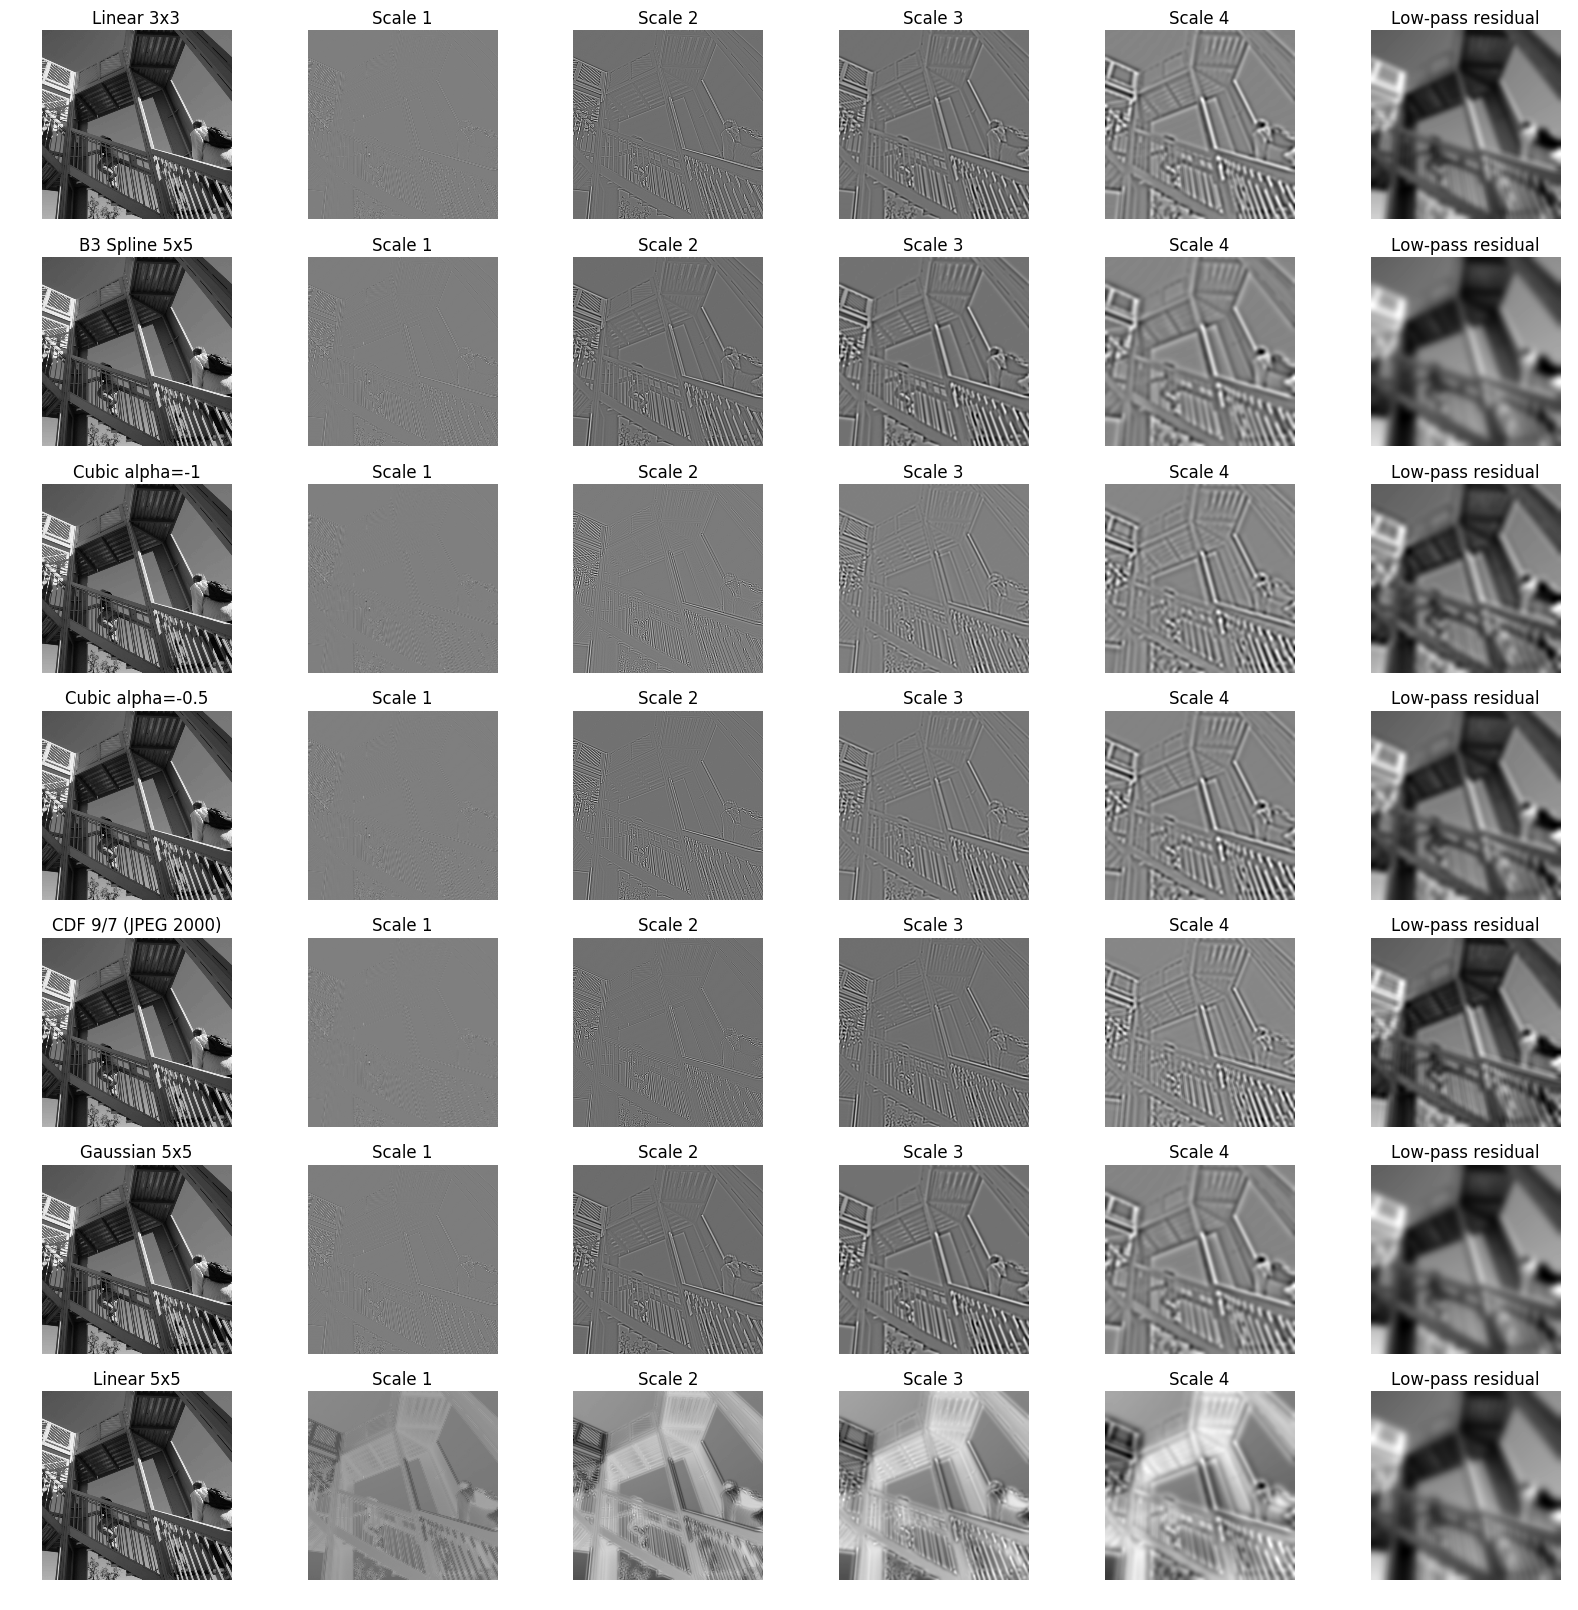

In [7]:
nscales = 4

kernel_names = libatrous.get_names()
n_kernel = len(kernel_names)

fig, subplots = plt.subplots(n_kernel,nscales+2)

ascent = scipy.misc.ascent()

for j in range(n_kernel):

    kernel = libatrous.get_kernel(j)
    print("Kernel %s coefficients: %s" % (kernel_names[j],str(kernel)))

    scales = [ascent]+get_scales(ascent,nscales,kernel)

    for i in range(nscales+2):
        if i == 0:
            title = kernel_names[j]
        elif i == nscales+1:
            title = "Low-pass residual"
        else:
            title = "Scale %d" % (i)
        
        ax = subplots[j][i]
        ax.imshow(scales[i],cmap='gray')
        ax.set_axis_off()
        ax.set_title(title)

# Working with 3-D arrays, a small caveat:

By using [separable kernels](https://en.wikipedia.org/wiki/Separable_filter), input arrays can in principle be of any dimension. However, only 1-D, 2-D and 3-D arrays are recognised for now.

When using libatrous to filter 3-D microscopy images, voxels often do not have the same dimension in X,Y and Z. This needs to be accounted for to avoid over-emphasising any of the X,Y or Z directions.

Voxel dimensions are input using the following command (for a 0.24,0.24,1.00um voxel):

In [8]:
libatrous.set_grid(0.24,0.24,1)

This is done during calculations by considering the (equivalent) nearest neigbour at the requested position.